# Sales data from 2016 to 2024

## 1 Data

In [1]:
def get_basic_weight(x):
    data = str(x).strip('[]').replace('\'', '').replace('/', ',').replace('●', ',').replace(' ', '').split(',')
    data = [s for s in data if any(char.isdigit() for char in s)]
    if data:
        data = max(data,key=data.count)
        return int(data)
    else:
        return None

def get_basic_brake(x):
    data = str(x).strip('[]').replace('\'', '').replace('/', ',').replace('●', ',').replace(' ', '').split(',')
    data = max(data,key=data.count)
    if '通风盘式' in data:
        return 'ventiled'
    elif '盘式' in data:
        return 'disc'
    elif '鼓式' in data:
        return 'drum'
    else:
        return None

car_map = {
    'SUV': 'SUV', 
    'MPV': 'MPV',
    '微型车': 'microcar',
    '小型车': 'small car',
    '紧凑型车': 'compact car',
    '中型车': 'mid-size car',
    '中大型车': 'large car',
    '大型车': 'luxury car',
    '跑车': 'sports car',
    '不限': None
}

def get_class(x):
    data = str(x).strip('[]').replace('\'', '').replace('/', ',').replace('●', ',').replace(' ', '').split(',')
    data = max(data,key=data.count)
    for k,v in car_map.items():
        if k in data:
            return v

def get_fuel_type(x):
    data = str(x).strip('[]').replace('\'', '').replace('/', ',').replace('●', ',').replace(' ', '').split(',')
    data = max(data,key=data.count)
    if '汽油' in data:
        return 'ICEV'
    elif '纯电动' in data:
        return 'BEV'
    elif '混' in data:
        return 'HEV'
    else:
        return 'others'

In [2]:
import pandas as pd

sales = pd.DataFrame([])
for year in range(2007, 2024, 1):
    raw = pd.read_excel('./data/car_sale_%d.xlsx' % int(year))
    raw.reset_index(drop=True, inplace=True)
    sale = raw.copy()
    sale['weight'] = sale['weight'].map(get_basic_weight)
    sale['frontB'] = sale['frontB'].map(get_basic_brake)
    sale['rearB'] = sale['rearB'].map(get_basic_brake)
    sale['fuel'] = sale['fuel'].map(get_fuel_type)
    sale['class'] = sale['class'].map(get_class)
    sale['year'] = int(year)
    sales = pd.concat([sales, sale])
# sales.dropna(inplace=True)

In [3]:
sales[['year', 'sales']].groupby(by=['year']).sum()

,sales
year,
2007,9807885
2008,9913982
2009,11877272
2010,13707392
2011,16919260
2012,19139120
2013,24136804
2014,26177102
2015,26448363


## 2 Analysis

In [4]:
LDV_sales = sales[sales['class'].isin(['small car', 'compact car', 'mid-size car', 'large car', 'SUV'])]
# LDV_sales = LDV_sales[LDV_sales['fuel'].isin(['ICEV', 'BEV', 'REEV', 'HEV'])]
# LDV_sales['fuel'].replace({'BEV':'EV', 'REEV':'EV', 'HEV':'EV'}, inplace=True)

In [5]:
LDV_sales.to_excel("data/car_sale_LDV_2007_23.xlsx", index=False)

In [6]:
# expand according to sales
expanded_data = []
for index, row in LDV_sales.iterrows():
    expanded_data.extend([(row['model'], row['sales'], row['class'], row['fuel'], row['weight'], row['frontB'], row['rearB'], row['year'])] * int(row['sales'] / 100))
expanded_LDV_sales = pd.DataFrame(expanded_data, columns=LDV_sales.columns[:-2].to_list() + ['year'])

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

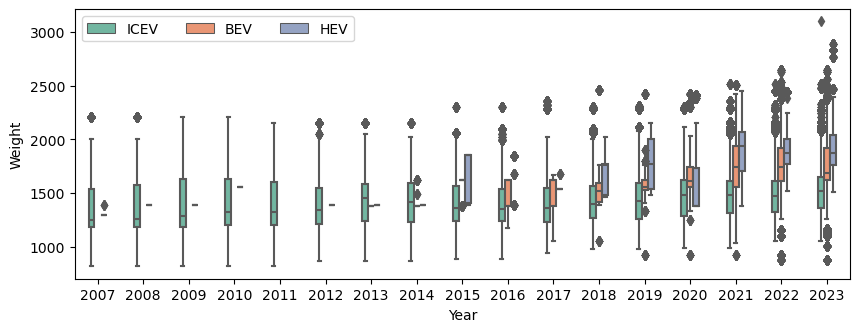

In [8]:
plt.figure(figsize=(10,3.5))
sns.boxplot(
    x='year', 
    y='weight', 
    hue='fuel', 
    hue_order=['ICEV', 'BEV', 'HEV'],
    data=expanded_LDV_sales, 
    palette='Set2',
    width=0.4
)

# color='navy'
# means = expanded_LDV_sales.groupby(['year', 'fuel'], as_index=False)['weight'].mean()
# plt.plot(np.arange(10), means[means['fuel'] == 'ICEV']['weight'], 'o--', color=color, alpha=0.7, label='ICEV mean')
# for xi, yi in zip(np.arange(10), means[means['fuel'] == 'ICEV']['weight']):
#     plt.text(xi, yi-100, '%d'%yi, ha='center', va='top', color=color, fontsize=10)
# plt.plot(np.arange(10), means[means['fuel'] == 'EV']['weight'], 'D--', color=color, alpha=0.7, label='EV mean')
# for xi, yi in zip(np.arange(10), means[means['fuel'] == 'EV']['weight']):
#     plt.text(xi, yi+100, '%d'%yi, ha='center', va='bottom', color=color, fontsize=10)

plt.legend(loc=2, ncols=3)
plt.xlabel('Year')
plt.ylabel('Weight')
plt.show()

<Axes: xlabel='year', ylabel='sales'>

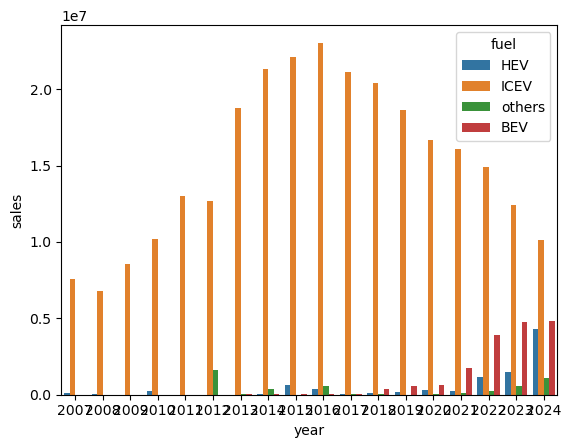

In [29]:
sns.barplot(LDV_sales.groupby(['year', 'fuel'], as_index=False)['sales'].sum(), x='year', y='sales', hue='fuel')

<Axes: xlabel='year', ylabel='prop'>

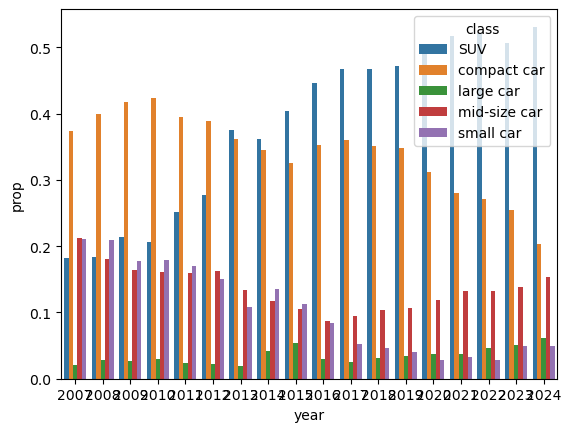

In [30]:
sales_year = LDV_sales.groupby(['year'], as_index=False)['sales'].sum()
sales_year_class = LDV_sales.groupby(['year', 'class'], as_index=False)['sales'].sum()
sales_year_class = sales_year_class.merge(sales_year, on='year')
sales_year_class['prop'] = sales_year_class['sales_x'] / sales_year_class['sales_y']

sns.barplot(sales_year_class, x='year', y='prop', hue='class')

## consider vehicle age

In [9]:
weights = pd.DataFrame([], columns=['year', 'icev', 'bev', 'hev', 'ev'])
for year in range(2016, 2024):
    if year < 2007 + 13:
        weight_icev = expanded_LDV_sales[
            (expanded_LDV_sales['year'] <= year) &
            (expanded_LDV_sales['fuel'] == 'ICEV')
        ]['weight'].mean()
        weight_hev = expanded_LDV_sales[
            (expanded_LDV_sales['year'] <= year) &
            (expanded_LDV_sales['fuel'] == 'HEV')
        ]['weight'].mean()
    else:
        weight_icev = expanded_LDV_sales[
            (expanded_LDV_sales['year'] <= year) &
            (expanded_LDV_sales['year'] > year-13) &
            (expanded_LDV_sales['fuel'] == 'ICEV')
        ]['weight'].mean()
        weight_hev = expanded_LDV_sales[
            (expanded_LDV_sales['year'] <= year) &
            (expanded_LDV_sales['year'] > year-13) &
            (expanded_LDV_sales['fuel'] == 'HEV')
        ]['weight'].mean()
    weight_bev = expanded_LDV_sales[
        (expanded_LDV_sales['year'] <= year) &
        (expanded_LDV_sales['year'] > year-6) &
        (expanded_LDV_sales['fuel'] == 'BEV')
    ]['weight'].mean()
    weight_ev = 0.8 * weight_bev + 0.2 * weight_hev
    weights.loc[weights.shape[0]] = [year, weight_icev, weight_bev, weight_hev, weight_ev]

In [10]:
weights.to_csv("data/weights_2016_2023.csv", index=False)